In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

### Connect to database

In [2]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver1 = 'SQL+Server'
driver2 = 'ODBC+Driver+18+for+SQL+Server'
string1 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver1}" 
string2 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver2}" 
try: 
    conn = create_engine(string1).connect()
except:
    conn = create_engine(string2).connect() 

### Get adjusted closing prices and calculate returns and returns in excess of median

In [3]:
import pandas as pd 
price = pd.read_sql(
    """ 
    select date, ticker, closeadj from sep_weekly 
    where date>='2010-01-01'
    order by ticker, date  
    """,
    conn,
    parse_dates = ["date"],
    index_col = ["ticker", "date"]
)

ret = price.groupby("ticker", group_keys=False).pct_change()
target = ret.groupby("date", group_keys=False).apply(lambda x: x - x.median())

### Compute moving averages and ratios

- Compute 4 week, 13 week, 26 week, and 52 week moving averages
- Define ratios to use as predictors:
  - 4 week moving avg / 13 week moving avg
  - 4 week moving avg / 26 week moving avg
  - 4 week moving avg / 52 week moving avg

In [30]:
ma4 = price.groupby("ticker", group_keys=False).rolling(4).closeadj.mean()
ma13 = price.groupby("ticker", group_keys=False).rolling(13).closeadj.mean()
ma26 = price.groupby("ticker", group_keys=False).rolling(26).closeadj.mean()
ma52 = price.groupby("ticker", group_keys=False).rolling(52).closeadj.mean()
for d in [ma4, ma13, ma26, ma52]:
    d.index = d.index.droplevel(0)
ratio_4_13 = ma4/ma13
ratio_4_26 = ma4/ma26
ratio_4_52 = ma4/ma52

### Compute dummy variables for crossovers as additional predictors

- Ratio switches from <1 to >1 when short term moves above long term
- Ratio switches from >1 to <1 when short term moves below long term

In [31]:
ratio_4_13_lag = ratio_4_13.groupby("ticker", group_keys=False).shift()
ratio_4_26_lag = ratio_4_26.groupby("ticker", group_keys=False).shift()
ratio_4_52_lag = ratio_4_52.groupby("ticker", group_keys=False).shift()

below_to_above_4_13 = 1 * ((ratio_4_13_lag<1) & (ratio_4_13>1))
above_to_below_4_13 = 1 * ((ratio_4_13_lag>1) & (ratio_4_13<1))
below_to_above_4_26 = 1 * ((ratio_4_26_lag<1) & (ratio_4_26>1))
above_to_below_4_26 = 1 * ((ratio_4_26_lag>1) & (ratio_4_26<1))
below_to_above_4_52 = 1 * ((ratio_4_52_lag<1) & (ratio_4_52>1))
above_to_below_4_52 = 1 * ((ratio_4_52_lag>1) & (ratio_4_52<1))

### Example

- Look at 4 week and 13 week moving averages for AAPL since 2022.
- One of the predictors is ratio_4_13 = ma4/ma13
- Another predictor is below_to_above_4_13 = 1 when ma4 crosses ma13 from below and is 0 otherwise
- Another predictor is above_to_below_4_13 = 1 when ma4 crosses ma13 from above and is 0 otherwise

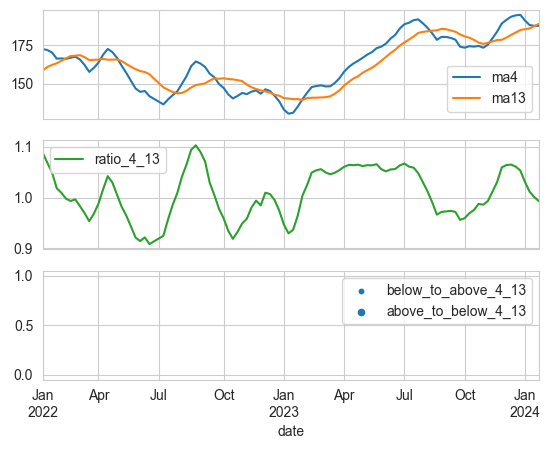

In [38]:
aapl_ma4 = ma4.loc["AAPL", "2022-01-01":].reset_index()
aapl_ma13 = ma13.loc["AAPL", "2022-01-01":].reset_index()
aapl_ratio_4_13 = ratio_4_13.loc["AAPL", "2022-01-01":].reset_index()
aapl_below_to_above_4_13 = below_to_above_4_13.loc["AAPL", "2022-01-01":].reset_index()
aapl_above_to_below_4_13 = above_to_below_4_13.loc["AAPL", "2022-01-01":].reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, )

aapl_ma4.plot(x="date", y="closeadj", label="ma4", ax=ax1)
aapl_ma13.plot(x="date", y="closeadj", label="ma13", ax=ax1)
ax1.legend()

aapl_ratio_4_13.plot(x="date", y="closeadj", label="ratio_4_13", c=sns.color_palette()[2], ax=ax2)
ax2.legend()

plt.scatter(
    x=aapl_below_to_above_4_13.date,
    y=aapl_below_to_above_4_13.closeadj,
    label="below_to_above_4_13",
    ax=ax3,
)
plt.scatter(
    x=aapl_above_to_below_4_13.date,
    y=aapl_above_to_below_4_13.closeadj,
    label="above_to_below_4_13",
    ax=ax3
)
ax3.legend()
ax3.set_ylabel("")
plt.show()

### Combine return, target, and predictors (and filter to price >= 10)

In [43]:
df = pd.concat(
    (
        ret, target, price.closeadj, ratio_4_13, ratio_4_26, ratio_4_52,
        below_to_above_4_13, below_to_above_4_26, below_to_above_4_52,
        above_to_below_4_13, above_to_below_4_26, above_to_below_4_52
    ),
    axis=1
)
df.columns = [
    "ret", "target", "price", "r1", "r2", "r3",
    "ba1", "ba2", "ba3", "ab1", "ab2", "ab3"
]
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["target"] = df.groupby("ticker", group_keys=False).target.shift(-1)

df = df[df.price>=10]
df = df.dropna()
df = df.reset_index()

df["year"] = df.date.map(lambda x: x.year)
df = df.sort_values(by=["date", "ticker"])
# df.to_csv("df.csv")

### Linear regression

In [44]:
string = """
    target ~ r1 + r2 + r3 + ba1 + ba2 + ba3 + ab1 + ab2 + ab3
"""
result = smf.ols(string, df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     74.19
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          6.49e-138
Time:                        10:15:58   Log-Likelihood:             2.3854e+06
No. Observations:             1991183   AIC:                        -4.771e+06
Df Residuals:                 1991173   BIC:                        -4.771e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0111      0.001     18.032      0.000       0.010       0.012
r1            -0.0126      0.001    -11.411      0.000      -0.015      -0.010
r2            -0.0031      0.001     -3.099      0.002      -0.005      -0.001
r3             0.0062      0.000     13.856      0.000       0.005       0.007
ba1           -0.0007      0.000     -2.563      0.010      -0.001      -0.000
ba2           -0.0006      0.000     -1.845      0.065      -0.001     3.7e-05
ba3           -0.0007      0.000     -1.886      0.059      -0.002    2.88e-05
ab1            0.0007      0.000      2.702      0.007       0.000       0.001
ab2            0.0011      0.000      3.350      0.001       0.000       0.002
ab3            0.0023      0.000      5.921      0.000       0.002       0.003
==============================================================================
Omnibus:                  4515330.915   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     654101665640.016
Skew:                          20.415   Prob(JB):                         0.00
Kurtosis:                    2810.545   Cond. No.                         58.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Backtest a random forest

Performance will be evaluated beginning Jan 1 of start_year, using all prior data for the first training episode.

In [52]:
start_year = 2014

features = [
    "r1", "r2", "r3", "ba1", "ba2", "ba3", "ab1", "ab2", "ab3"  
]
df2 = None 
forest = RandomForestRegressor(max_depth=4)

for year in range(start_year, 2024):
    print(year)
    start = df[df.year == year].date.min()
    past = df[df.date < start]
    future = df[df.year == year].copy()
    forest.fit(X=past[features], y=past["target"])
    future["predict"] = forest.predict(X=future[features])
    df2 = pd.concat((df2, future))

# df2.to_csv("df2.csv", index=False)
df2.head()

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


,ticker,date,ret,target,price,r1,r2,r3,ba1,ba2,ba3,ab1,ab2,ab3,year,predict
158,A,2014-01-03,-0.011847,-0.008989,38.070,1.055569,1.119108,1.206591,0,0,0,0,0,0,2014,0.001996
1985,AAMC,2014-01-03,0.008446,0.011304,543.935,1.268693,1.725940,2.622415,0,0,0,0,0,0,2014,0.001902
2779,AAON,2014-01-03,-0.016095,-0.013237,13.110,1.099530,1.183112,1.400658,0,0,0,0,0,0,2014,0.001996
3462,AAP,2014-01-03,0.019802,0.022660,99.836,1.077874,1.194756,1.276213,0,0,0,0,0,0,2014,0.001996
4203,AAPL,2014-01-03,-0.030513,-0.027656,17.566,1.051060,1.126009,1.199000,0,0,0,0,0,0,2014,0.001996


### Compute portfolio returns

- Equally weighted portfolio of best stocks
- Equally weighted portfolio of worst stocks
- Equally weighted portfolio of all stocks

In [57]:
num_stocks = 50

grouped = df2.groupby("date", group_keys=False).predict
starting_from_best = grouped.rank(ascending=False, method="first")
best = df2[starting_from_best <= num_stocks]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = grouped.rank(ascending=True, method="first")
worst = df2[starting_from_worst <= num_stocks]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

### Plot performance

- Set logy = True to get a log plot.  
- In a log plot, the slope of a curve represents the percent change in the y variable per unit change in the x variable.

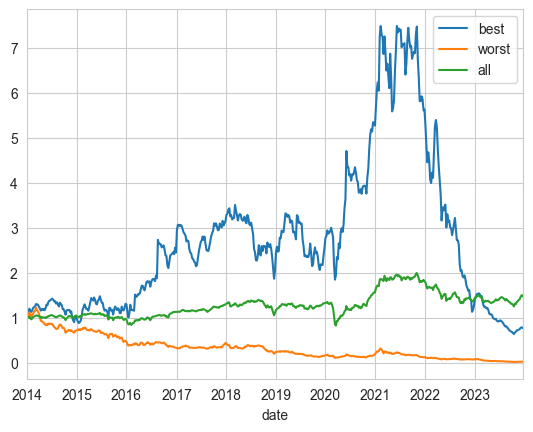

In [58]:
logy = False 

(1+best_rets).cumprod().plot(label="best", logy=logy)
(1+worst_rets).cumprod().plot(label="worst", logy=logy)
(1+all_rets).cumprod().plot(label="all", logy=logy)
plt.legend()
plt.show()

### Compare features of best and worst stocks

Look at portfolios on final date of backtest.

In [61]:
best_today = best[best.date == best.date.max()]
worst_today = worst[worst.date == worst.date.max()]
b = best_today[features].describe().iloc[1:].T
b.index.name = "stat"
b["group"] = "best"
b = b.reset_index().set_index(["stat", "group"])
w = worst_today[features].describe().iloc[1:].T
w.index.name = "stat"
w["group"] = "worst"
w = w.reset_index().set_index(["stat", "group"])
d = pd.concat((b, w))
d = d.unstack()
d.round(2)

mean         std         min         25%         50%         75%        \
group  best worst  best worst  best worst  best worst  best worst  best worst   
stat                                                                            
ab1    0.04  0.02  0.20  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
ab2    0.06  0.02  0.24  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
ab3    0.32  0.00  0.47  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00   
ba1    0.00  0.12  0.00  0.33  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
ba2    0.02  0.00  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
ba3    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
r1     1.03  1.13  0.06  0.34  0.86  0.56  0.99  0.93  1.03  1.02  1.07  1.16   
r2     1.01  1.01  0.07  0.55  0.84  0.23  0.98  0.72  1.02  0.78  1.06  0.90   
r3     1.04  0.91  0.09  0.80  0.84  0.01  0.99  0.53  1.02  0.61  1.06  0.66   

        max        
group  best worst  
stat               
ab1    1.00  1.00  
ab2    1.00  1.00  
ab3    1.00  0.00  
ba1    0.00  1.00  
ba2    1.00  0.00  
ba3    0.00  0.00  
r1     1.13  1.95  
r2     1.13  2.53  
r3     1.32  3.35

### Plot distributions of individual features

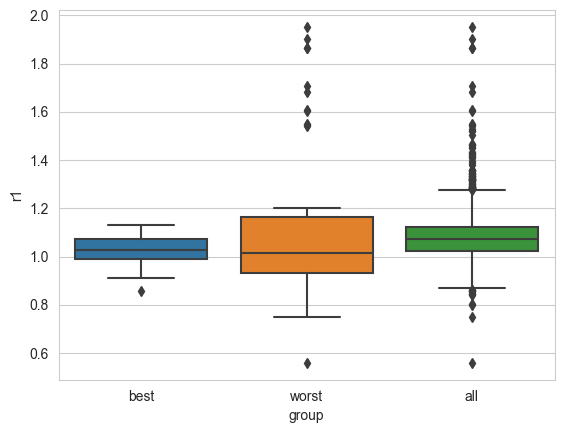

In [60]:
feature = "r1"

b2 = pd.DataFrame(best_today[feature])
b2["group"] = "best"
w2 = pd.DataFrame(worst_today[feature])
w2["group"] = "worst"
a2 = df[df.date == best.date.max()]
a2 = pd.DataFrame(a2[feature])
a2["group"] = "all"
d2 = pd.concat((b2, w2, a2))
sns.boxplot(data=d2, x="group", y=feature)
plt.show()